# Planning Methods: Part II, Spring 2021

# Lab 3: Correlations and Regressions

**About This Lab**
* We will be running through this notebook together. If you have a clarifying question or other question of broad interest, feel free to interrupt or use a pause to unmute and ask it! If you have a question that may result in a one-on-one breakout room (think: detailed inquiry, conceptual question, or help debugging), please ask it in the chat!
* We recognize learning Python via Zoom comes with its challenges and that there are many modes of learning. Please go with what works best for you. That might be printing out the Jupyter notebook, duplicating it such that you can refer to the original, working directly in it. Up to you! There isn't a single right way.
* This lab requires that you download the following file and place it in the same directory as this Jupyter notebook:
    * `clean_property_data.csv`
* This data includes properties that were sold through a real estate site (like Zillow) between 2001 and 2006 in Bogota. There are apartments and houses, characteristics of the structure like area and bathrooms, and characteristics of the neighborhood like density and a proxy for neighborhood income which is called SES.

## Objectives
By the end of this lab, you will have reviewed how to:
>1. Call a correlation matrix
>2. Run a bivariate linear regression

You will also learn how to:
>1. Run a bivariate linear regression with a binary independent variable
>2. Run a multivariable linear regression with binary independent variables

As discussed in lecture, planners can use regressions in a multitude of ways, from diagnosing a problem or bringing it to light, to determining at what level to intervene, to assessing the impact of an intervention. The kind of regression you will run depends on what phenomenon you want to understand (your dependent variable) and what factor(s) you hypothesize may be associated with it (your independent variables; explanatory or control variables).

## 1 Import packages and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from scipy.stats import pearsonr

In [2]:
# read in data
data = pd.read_csv('clean_property_data.csv')
data.head()

,id,price_000,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,apt,floor,...,pcnt_indu,pcnt_com,pcnt_insti,pcnt_vacant,pcn_green,thefts,house,ses_bin,lnprice,price_hi
0,40003,60000,1,0,0,0,0,0,1,5,...,0.0,0.00,0.49,0.0,1.74,39.92,0,0,11.00210,0
1,40007,140000,0,1,0,0,0,0,0,0,...,0.0,15.41,1.32,0.0,0.54,46.00,1,0,11.84940,1
2,40008,38000,0,1,0,0,0,0,1,1,...,0.0,8.16,5.57,0.0,1.55,45.87,0,0,10.54534,0
3,40010,110000,0,1,0,0,0,0,0,0,...,0.0,8.11,5.53,0.0,1.58,45.88,1,0,11.60824,1
4,40011,120000,0,1,0,0,0,0,0,0,...,0.0,0.00,0.00,0.0,0.40,46.00,1,0,11.69525,1


In [3]:
# create sub-dataframe
df = data[['price_000','pop_dens','ses','house','area_m2','num_bath','pcn_green','thefts']].copy()

## 2 Correlation matrix

In [4]:
# correlation matrix for all variables
df.corr()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts
price_000,1.000000,0.025395,0.332310,0.272182,0.632867,0.438951,-0.024504,-0.140996
pop_dens,0.025395,1.000000,-0.066464,0.186380,0.169518,0.085829,-0.030906,0.122644
ses,0.332310,-0.066464,1.000000,-0.147592,0.101272,0.080532,0.052955,-0.272214
house,0.272182,0.186380,-0.147592,1.000000,0.651771,0.391207,-0.071164,0.002256
area_m2,0.632867,0.169518,0.101272,0.651771,1.000000,0.530402,-0.081659,-0.155758
num_bath,0.438951,0.085829,0.080532,0.391207,0.530402,1.000000,0.004428,-0.023408
pcn_green,-0.024504,-0.030906,0.052955,-0.071164,-0.081659,0.004428,1.000000,0.400809
thefts,-0.140996,0.122644,-0.272214,0.002256,-0.155758,-0.023408,0.400809,1.000000


In [5]:
# function for matrix of p-values (thank you, Jonathan!)
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

corr = df.corr(method=pearsonr_pval)
corr

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts
price_000,1.000000e+00,1.093673e-01,3.991591e-103,1.757399e-68,0.000000e+00,5.777945e-187,1.223729e-01,4.166382e-19
pop_dens,1.093673e-01,1.000000e+00,2.737746e-05,2.087070e-32,5.108902e-27,5.949682e-08,5.133684e-02,8.474575e-15
ses,3.991591e-103,2.737746e-05,1.000000e+00,8.371958e-21,1.551396e-10,3.683541e-07,8.365027e-04,1.691778e-68
house,1.757399e-68,2.087070e-32,8.371958e-21,1.000000e+00,0.000000e+00,1.478265e-145,7.069447e-06,8.869123e-01
area_m2,0.000000e+00,5.108902e-27,1.551396e-10,0.000000e+00,1.000000e+00,2.020881e-287,2.522505e-07,5.152606e-23
num_bath,5.777945e-187,5.949682e-08,3.683541e-07,1.478265e-145,2.020881e-287,1.000000e+00,7.801394e-01,1.400141e-01
pcn_green,1.223729e-01,5.133684e-02,8.365027e-04,7.069447e-06,2.522505e-07,7.801394e-01,1.000000e+00,2.374363e-153
thefts,4.166382e-19,8.474575e-15,1.691778e-68,8.869123e-01,5.152606e-23,1.400141e-01,2.374363e-153,1.000000e+00


## 3 Bivariate linear regression
A simple linear regression—also known as a binary linear regression—is one where the dependent variable is continuous and is “simple” only because there is one independent or explanatory variable to explore. We’re going to start with exploring the possible relationship between two continuous variables to practice that interpretation.

### 3.1 Hypothesis 1: neighborhood population density is associated with higher property values

#### 3.1.1 Explore your variables (descibe and visualize)

In [6]:
# define a function to set up boxplot and histogram side by side

def plots (df, var, title, box_label, hist_label):
    # set up figure for two subplots: boxplot & histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # define subplots and figure size
    plt.suptitle(title) # title the figure
    
    ### boxplot
    ax1.boxplot(var)
    ax1.set_ylabel(box_label)
    ### format axes to include thousands separator
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))

    ### histogram
    ax2.hist(var)
    ax2.set_xlabel(hist_label)
    ### format axes number to include thousands separator
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x2, loc: "{:,}".format(int(x2))))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x2, loc: "{:,}".format(int(x2))))
    ax2.tick_params(axis='x', labelrotation=35)

    plt.show()

In [7]:
# set up variables
x = df['pop_dens'] # define independent variable
y = df['price_000'] # define dependent variable

count    3976.000000
mean      470.319977
std       237.467271
min        16.180000
25%       277.840000
50%       416.320000
75%       660.590000
max       986.730000
Name: pop_dens, dtype: float64


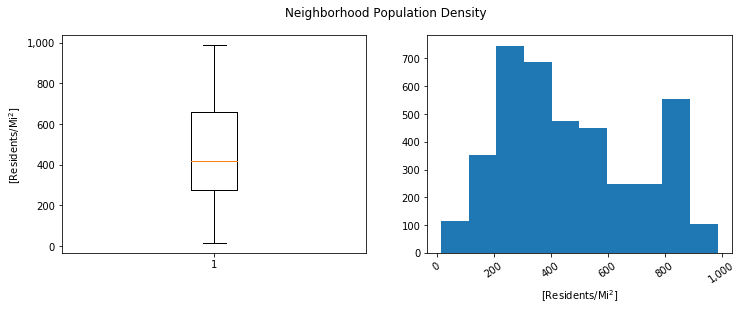

In [8]:
# describe neighborhood density
var = x
title = 'Neighborhood Population Density'
box_label = '[Residents/Mi$^2$]'
hist_label = '[Residents/Mi$^2$]'

print(var.describe())
plots(df, var, title, box_label, hist_label)

count      3976.000000
mean      93511.045523
std       75516.069987
min       20000.000000
25%       50000.000000
50%       72000.000000
75%      110000.000000
max      800000.000000
Name: price_000, dtype: float64


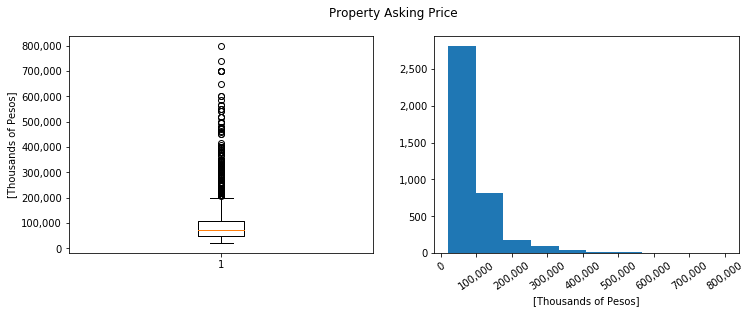

In [9]:
# describe property price
var = y
title = 'Property Asking Price'
box_label = '[Thousands of Pesos]'
hist_label = '[Thousands of Pesos]'

print(var.describe())
plots(df, var, title, box_label, hist_label)

#### 3.1.2 Visualize the relationship (scatterplot)
Like we did last lab, we’ll now draw a scatterplot with our two variables to get a visual sense of how these variables move together. We’ll also add a line of best fit, a straight line drawn through the center of the data points that minimizes the total sum of squared distances between the line and each data point to give a general picture of the trend in the data.

We're using the Seaborn library here (as opposed to Matplotlib) because it's better at incorporating the line of best fit, and it generally produces more nuanced visualizations.

In [10]:
# define a function to show and style regression scatterplot
def reg_scatter(df, x, y, xlabel, ylabel, color):
    plt.figure(figsize=(10,6))

    ax = sns.regplot(x, y, data=df, line_kws=color) 

    ax.set(xlabel=xlabel, ylabel=ylabel);
    ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [11]:
# set up parameters for plot function
xlabel = 'Neighborhood Population Density [Residents/Mi$^2$]'
ylabel = 'Property Asking Price [Thousands of Pesos]'
color = {'color':'red'}

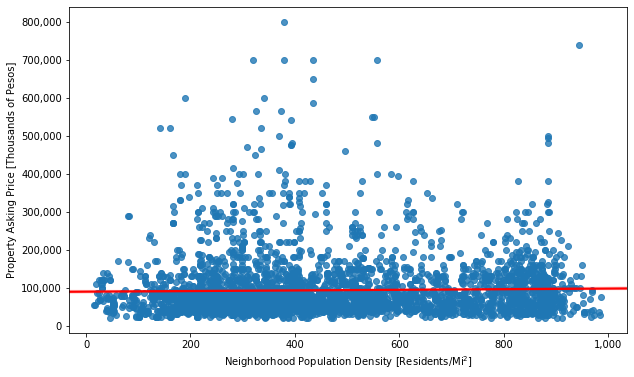

In [12]:
reg_scatter(df, x, y, xlabel, ylabel, color)

#### 3.1.3 Pairwise correlation
What do we notice about this scatterplot? Let’s run a correlation of these two variables (aka a 'pairwise' correlation) to see how strong the relationship is.

In [13]:
# returns a Pearson’s correlation coefficient for each pair specified
var_list = ['pop_dens', 'price_000']
df[var_list].corr()

,pop_dens,price_000
pop_dens,1.000000,0.025395
price_000,0.025395,1.000000


In [14]:
# pairwise correlation with significance
# returns a Pearson’s correlation coefficient, 2-tailed p-value
pearsonr(x, y)

(0.025394898568317177, 0.10936728425905742)

It looks like this isn't a statistically significant relationship, but let’s take a closer look with a regression anyway! We hypothesized that neighborhood density might be an explanatory variable for a property's asking price, so pop_dens will be our X and price_000 will be our Y.

#### 3.1.4 Bivariate linear regression
Before we run our regression, let’s review what we’re looking for:

> • RQ:  
> • H0:  
> • HA:  

In [15]:
# bivariate linear regression
x = df[['pop_dens']].assign(Intercept = 1) # redefine independent variable and include intercept

sm.OLS(y, x).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: price_000        AIC:                100601.4994
Date:               2021-02-10 14:04 BIC:                100614.0754
No. Observations:   3976             Log-Likelihood:     -50299.    
Df Model:           1                F-statistic:        2.564      
Df Residuals:       3974             Prob (F-statistic): 0.109      
R-squared:          0.001            Scale:              5.7004e+09 
--------------------------------------------------------------------
             Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
--------------------------------------------------------------------
pop_dens       8.0757    5.0429  1.6014 0.1094    -1.8112    17.9627
Intercept  89712.8657 2656.8905 33.7661 0.0000 84503.8694 94921.8619
--------------------------------------------------------------------
Omnibus:              2831.841      Durbin-Watson:         0.353    
Prob(Omnibus):        0.000         Jarque-Bera (JB):      47484.533
Skew:                 3.262         Prob(JB):              0.000    
Kurtosis:             18.622        Condition No.:         1169     
====================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

Let's answer the following questions:
> • How can you explain the impact of population density on the asking price of a property?  
> • Is our model statistically significant?   
> • How can you tell?   

We're bound to run into insignificant findings, particularly as we work with complex topics and datasets in city planning. However these results can still be revealing and teach us about our research question and/or the dataset.

### 3.2 Hypothesis 2: high SES neighborhoods (ses_bin=6 is highest) are associated with higher property values

In [16]:
# set up variables
x = df['ses'] # independent variable
y = df['price_000'] # dependent variable

xlabel = 'Neighborhood Socioeconomic Satus'
ylabel = 'Property Asking Price [Thousands of Pesos]'

#### 3.2.1 Explore your variables (describe and recode)

In [17]:
# describe SES & price
stats = ['count','min','max','mean', 'median', 'std']
y.groupby(x).agg(stats)

,count,min,max,mean,median,std
ses,,,,,,
1,26,20000,700000,266953.846154,250000,179357.852866
2,79,21000,150000,50664.822785,40000,28741.165509
3,2105,20000,564425,73547.928741,60000,49480.348888
4,1448,20000,740000,101629.808702,82000,71465.271681
5,227,23000,800000,170825.299559,130000,118376.845077
6,91,42000,699800,220889.010989,200000,124550.539899


We’re interested in the difference between high and low SES status, so we can simplify this categorical variable into a dummy in which those that are rated 5 & 6 are coded 1, and all others are coded 0.  

In [18]:
# recode SES to high SES dummy variable
df['ses_dv'] = np.where((df['ses']>=5), 1, 0) # create dummy variable: 1 = high SES, 0 = lower SES
x = df['ses_dv'] # reassign independent X variable

y.groupby(x).agg(stats)

,count,min,max,mean,median,std
ses_dv,,,,,,
0,3658,20000,740000,85544.470749,70000,64128.942717
1,318,23000,800000,185151.707547,150000,122099.441800


#### 3.2.2 Visualize the relationship (scatterplot)

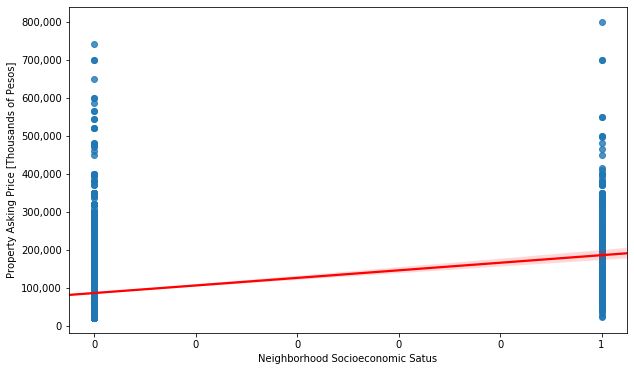

In [19]:
reg_scatter(df, x, y, xlabel, ylabel, color)

#### 3.2.3 Pairwise correlation

In [20]:
pearsonr(x, y)

(0.35784517717635483, 2.002158271320834e-120)

#### 3.2.4 Bivariate linear regression

In [21]:
x = df[['ses_dv']].assign(Intercept = 1) # reassign independent variable w/ intercept

sm.OLS(y, x).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.128      
Dependent Variable: price_000        AIC:                100059.2456
Date:               2021-02-10 14:04 BIC:                100071.8217
No. Observations:   3976             Log-Likelihood:     -50028.    
Df Model:           1                F-statistic:        583.6      
Df Residuals:       3974             Prob (F-statistic): 2.00e-120  
R-squared:          0.128            Scale:              4.9737e+09 
--------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025      0.975]  
--------------------------------------------------------------------
ses_dv    99607.2368 4123.1278 24.1582 0.0000 91523.5928 107690.8808
Intercept 85544.4707 1166.0500 73.3626 0.0000 83258.3585  87830.5830
--------------------------------------------------------------------
Omnibus:              2795.814      Durbin-Watson:         0.532    
Prob(Omnibus):        0.000         Jarque-Bera (JB):      53224.549
Skew:                 3.146         Prob(JB):              0.000    
Kurtosis:             19.784        Condition No.:         4        
====================================================================

"""

When interpreting our regression output, we are most interested in the value of **b**, from our regression equation, which is the coefficient of each explanatory variable, shown as 'Coef.' above. The value of b tells us how much Y changes when X changes. Remember: It doesn’t necessarily imply a causal relationship, just an association.

> In this case, because X is a dummy variable, it changes from 0 (lower SES) to 1 (high SES). Take a moment to interpret these findings - how does high socioeconomic status impact the price of a property?

## 4 Multivariable linear regression

After creating a “simple” model (i.e. one explanatory variable), we can start to build a more sophisticated model by including additional explanatory variables or “controls”. Let’s take our ses_dv variable from our simple linear regression: what else do we think might influence a property's listing price, in addition to whether it's in a high socioeconomic status neighborhood?  


From our extensive literature review, we know that there might be property-specific and neighborhood-level factors which influence a property's price. We hypothesize that a property's type, size, and number of bathrooms, in addition to the neighborhood's green space and theft rate, might be helpful predictors of a property's price.

In [22]:
# define independent variables
ind_var = ['ses_dv', 'house', 'area_m2', 'num_bath', 'pcn_green', 'thefts'] 
# generally, first variable is your 'key explanatory variable', followed by your control variables

x = df[ind_var].assign(Intercept = 1) # independent variables
y = df['price_000'] # dependent variable

sm.OLS(y, x).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.516     
Dependent Variable:   price_000         AIC:                 97723.9942
Date:                 2021-02-10 14:04  BIC:                 97768.0104
No. Observations:     3976              Log-Likelihood:      -48855.   
Df Model:             6                 F-statistic:         706.9     
Df Residuals:         3969              Prob (F-statistic):  0.00      
R-squared:            0.517             Scale:               2.7609e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
ses_dv     71903.0480 3184.0260  22.5824 0.0000  65660.5680  78145.5280
house     -28286.1727 2442.5647 -11.5805 0.0000 -33074.9718 -23497.3736
area_m2      566.6890   14.4087  39.3297 0.0000    538.4399    594.9381
num_bath   10104.0034  957.5726  10.5517 0.0000   8226.6231  11981.3837
pcn_green    257.1769  116.1036   2.2151 0.0268     29.5487    484.8052
thefts       -25.0611   16.1898  -1.5480 0.1217    -56.8022      6.6800
Intercept   7001.9129 2489.8493   2.8122 0.0049   2120.4093  11883.4165
-----------------------------------------------------------------------
Omnibus:              3108.465       Durbin-Watson:          0.905     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       120952.385
Skew:                 3.387          Prob(JB):               0.000     
Kurtosis:             29.157         Condition No.:          659       
=======================================================================

"""

> • How would you interpret the coefficient for each variable?  
> • Which factors increase a property's asking price?    
> • Which decrease the asking price?  